scratch convnet model 

# Course: MIS 6/74061 – Advanced Machine Learning
# Assignment: 2. Convolution (Cat and Dog dataset)
## Miri Chung, ID: 811176241
## Date: November 06, 2022

### The purpose of this assignment is to see the relationship between the size of the training dataset and prediction accuracy. Also, the performance of the pretrained network on the test dataset is examined. In order to create a reproducible process and to be able to compare the results of each model, the seed number “42” is used throughout the assignment.

## <ins>Conclusion<ins>
### As a result of testing under various conditions, it can be concluded that a model’s accuracy is determined by the size of the training data and the architecture of the model when the model is directly trained with its own data. In contrast, the pretrained model’s accuracy depends on the set of test samples being evaluated. With a pretrained model, some sample sets may be more difficult than others, and robust results on one set will not necessarily fully translate to all other sets. 

### The training sample size and the architecture of the model have a significant effect on the accuracy of the test. The test accuracy increased dramatically when adding three modern architectures (i.e., residual connections, batch normalization, and depthwise separable convolutions) from a simple scratch model, along with data augmentation and dropout techniques. In addition, each model resulted in higher test accuracy when the training data was increased from 1,000 to 3,000. When training with this data up to 6,000, the test accuracy was similar to the pretrained performance. This is because overfitting is caused by having too few samples to learn from, making it impossible to train a model that can generalize to new data. Given more data, the model is exposed to more possible aspects of the data distribution at hand, leading to better test accuracy.

### However, when using a pretrained network, although its test accuracy was the highest, the size of the training sample does not significantly affect the test accuracy, because the model for measuring accuracy is not trained with the data it owns. In addition, since the amount of data used in the pretrained model, VGG16, must necessarily have been very large (The total number of parameters in VGG16 is over 138M, and the size of the model is over 500MB), other techniques such as data augmentation and fine-tuning do not significantly improve the accuracy, as the original pretrained model already has high-performance accuracy.

## <ins>Recommendation<ins>
### I believe that it is not always best to use pretrained models in all situations. The case for distinguishing between cat and dog pictures used in this task is context-independent – meaning that the background or context of the picture does not affect the dog versus cat distinction. Therefore, in the case of a pretrained model that distinguishes images, it can be used in any image distinction task as long as the sample images are in the same category as the target used to train the model.

### However, if the target to test is context-dependent, the pretrained model must be carefully selected. For example, in the case of a lexicon-pretrained model, the usage of the words in the model will be different depending on whether it was trained with medical data or legal text. In other words, it would not be appropriate to import and use a lexicon-pretrained model developed in medical terms for use in a culinary article. Rather, it is appropriate to create and use a model trained with the specific data owned. In this case, the size of the training data set and the architecture of the model significantly affect the performance of the model. Looking at the very simple scratch model used in this assignment, when the training data increased from 1,000 to 3,000, the accuracy improved dramatically (0.683 -> 0.839). In the condition of the 3,000 training dataset, using the three modern architectures plus data augmentation and dropout, the test accuracy came to close to 0.93. When training with this data up to 6,000, the test accuracy rose to almost 0.950, which was similar to the pretrained performance. However, the pretrained model did not significantly increase in accuracy when tested with 6,000 (Test accuracy: 0.976). These results further support the conclusion that the size of the training dataset and the architecture of the model are critical when training with their own data. Of course, it should be noted that the larger the dataset, the more computational resources and time are required.


## <ins> Model analysis <ins>
### The following is a summary of the results of several experiments that led to the above conclusion. 

### First, a scratch convnet model was built that stacks alternated Conv2D (with ReLU activation) and Maxpool layers. The model was run on 1,000 training images, 500 validation images, and 1,000 test images. The test accuracy of the scratch convnet model with 1,000 training images was 0.683. When the size of the training dataset was increased to 3,000, the test accuracy improved to 0.839.

### Next, the scratch model was advanced by applying three modern convnet architectures to improve its performance: residual connections, batch normalization, and depthwise separable convolutions. In the model, a residual connection was introduced as the input of a layer or block of layers back to its output (residual = x), so that it enables error gradient information from early layers to augment noiselessly through a deep network. Batch normalization makes different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data. In the model, the Batch normalization layer was placed after the convolution layers and before the layer’s activation (relu);  x = layers.BatchNormalization()(x). Finally, depthwise separable convolutions perform a spatial convolution on each channel of its input independently before mixing output channels via a pointwise convolution, which requires significantly fewer parameters and involves fewer computations compared to regular convolution. In the model, the Conv2D layers are replaced with SeparableConv2D; x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x). With these three architectures, the model has a better test accuracy of 0.780.  When the size of the training dataset was increased to 3,000, the test accuracy improved to 0.851.

### Now, in order to achieve even better performance, the model added a convnet with data augmentation and dropout. Data augmentation generates more training data from existing samples by augmenting the samples via a number of random transformations that yield believable-looking images. This helps expose the model to more aspects of the data so it can generalize better. In this case, data augmentation layers were added at the start of the model: x = data_augmentation(inputs).

### Because the images created by data augmentation come from a small number of original images, there is a possibility that the images are heavily intercorrelated with each other. Hence, to decrease overfitting, a dropout layer was added to the model right before the densely connected classifier: x = layers.dropout(0.5)(x). The test accuracy of this model was 0.863. When the size of the training dataset was increased to 3,000, the test accuracy improved to 0.929. When training with this data up to 6,000, the test accuracy rose to almost 0.950.

### Now let’s look at the performance of the pretrained model. When using the pretrained model, the test accuracy reached 0.975. This is, of course, a much better performance than the model created by training with its own data. Interestingly, the performance of the pretrained model did not improve even with data augmentation, as the test accuracy was still 0.975. In the condition of the 6,000 training dataset, the test accuracy was still 0.976.


### In fine-tuning, which consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, the test accuracy is improved very little (0.980). This was the case whether the size of the training dataset was 1,000 or 3,000. The test accuracy was about 0.971 ~ 0.974, and even in the last fine-tuning it was 0.980, similar to the condition of the 1,000 test sets. The test accuracy was highest when the training dataset was increased to 6,000 (test accuracy: 0.985)


In [5]:
from keras.utils import set_random_seed
set_random_seed(42)

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1500)
make_subset("train", start_index=1500, end_index=2500)

Building the model

In [7]:
set_random_seed(42)
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3))
x=layers.Rescaling(1./255)(inputs)
x=layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x=layers.Flatten()(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model=keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Configuring the model for training

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Data preprocessing

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Callback and fitting the model

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 35s 540ms/step - loss: 0.6808 - accuracy: 0.5490 - val_loss: 0.6350 - val_accuracy: 0.6280
Epoch 2/30
63/63 [==============================] - 33s 520ms/step - loss: 0.6561 - accuracy: 0.5850 - val_loss: 0.6514 - val_accuracy: 0.5910
Epoch 3/30
63/63 [==============================] - 33s 518ms/step - loss: 0.6526 - accuracy: 0.6045 - val_loss: 0.6388 - val_accuracy: 0.6310
Epoch 4/30
63/63 [==============================] - 33s 519ms/step - loss: 0.6266 - accuracy: 0.6555 - val_loss: 0.6514 - val_accuracy: 0.6010
Epoch 5/30
63/63 [==============================] - 33s 522ms/step - loss: 0.6034 - accuracy: 0.6780 - val_loss: 0.5918 - val_accuracy: 0.6790
Epoch 6/30
63/63 [==============================] - 33s 520ms/step - loss: 0.6113 - accuracy: 0.6615 - val_loss: 0.6150 - val_accuracy: 0.6780
Epoch 7/30
63/63 [==============================] - 33s 518ms/step - loss: 0.5528 - accuracy: 0.7250 - val_loss: 0.6191 - val_accuracy: 0.6840

Displaying curves of loss and accuracy during training

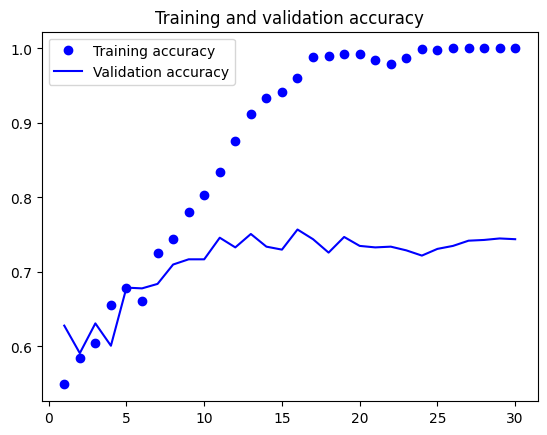

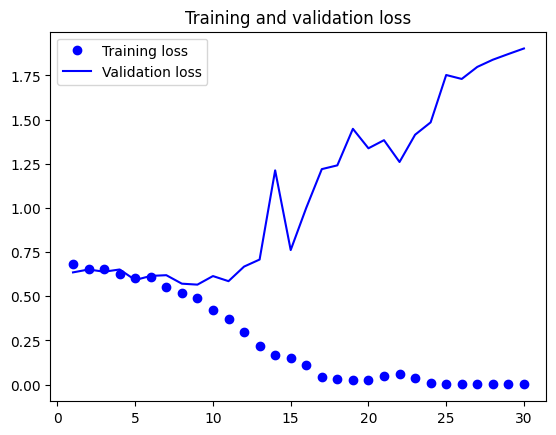

In [11]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Test Accuracy

In [12]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 8s 123ms/step - loss: 0.6073 - accuracy: 0.6825
Test accuracy:0.683


Scratch model with three modern convnet architectures 

Building the model

In [13]:
set_random_seed(42)
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 176, 176, 32  2400        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

Configuring the model for training

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Data preprocessing

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Callback and fitting the model

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_modern_architectures.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 108s 2s/step - loss: 0.6651 - accuracy: 0.5930 - val_loss: 0.7211 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 107s 2s/step - loss: 0.6402 - accuracy: 0.6325 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 106s 2s/step - loss: 0.6055 - accuracy: 0.6690 - val_loss: 0.7765 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 107s 2s/step - loss: 0.5856 - accuracy: 0.6910 - val_loss: 0.7466 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 107s 2s/step - loss: 0.5691 - accuracy: 0.7040 - val_loss: 0.8478 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 107s 2s/step - loss: 0.5196 - accuracy: 0.7450 - val_loss: 0.9641 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 107s 2s/step - loss: 0.4656 - accuracy: 0.7855 - val_loss: 0.9705 - val_accuracy: 0.5010
Epoch 

Displaying curves of loss and accuracy during training

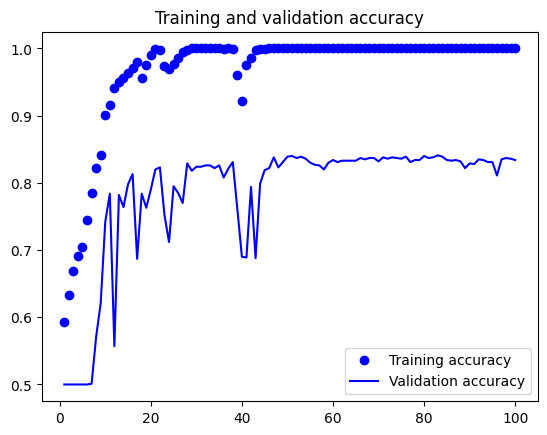

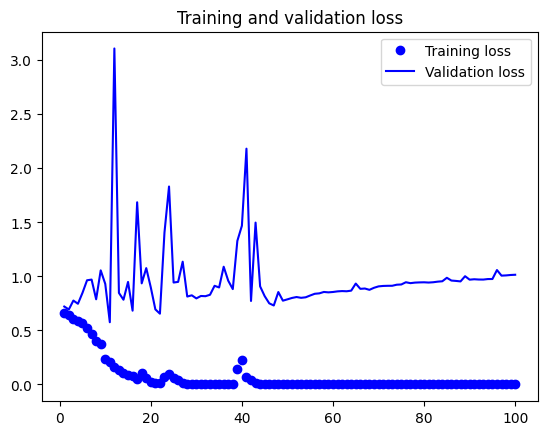

In [17]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


test accuracy 

In [18]:
test_model = keras.models.load_model("convnet_with_modern_architectures.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 18s 287ms/step - loss: 0.6168 - accuracy: 0.7800
Test accuracy:0.780


Scratch model with data Augmentation

Building the Model

In [19]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [20]:
set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 37s 548ms/step - loss: 0.6947 - accuracy: 0.5095 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 35s 548ms/step - loss: 0.6935 - accuracy: 0.5120 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 35s 551ms/step - loss: 0.6936 - accuracy: 0.5130 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 35s 552ms/step - loss: 0.6898 - accuracy: 0.5180 - val_loss: 0.6570 - val_accuracy: 0.5980
Epoch 5/100
63/63 [==============================] - 35s 552ms/step - loss: 0.6854 - accuracy: 0.5520 - val_loss: 0.6737 - val_accuracy: 0.5840
Epoch 6/100
63/63 [==============================] - 35s 554ms/step - loss: 0.6858 - accuracy: 0.5445 - val_loss: 0.6780 - val_accuracy: 0.5910
Epoch 7/100
63/63 [==============================] - 35s 551ms/step - loss: 0.6724 - accuracy: 0.5720 - val_loss: 0.6504 - val_accuracy:

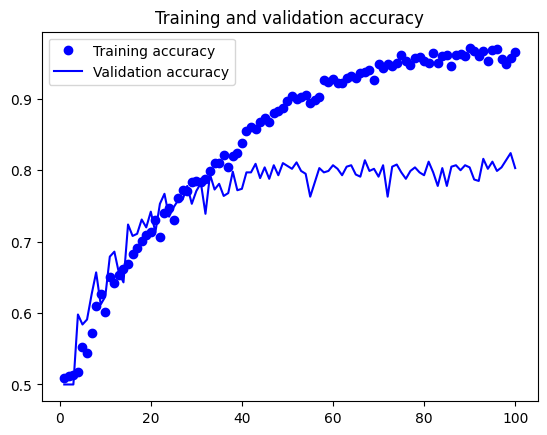

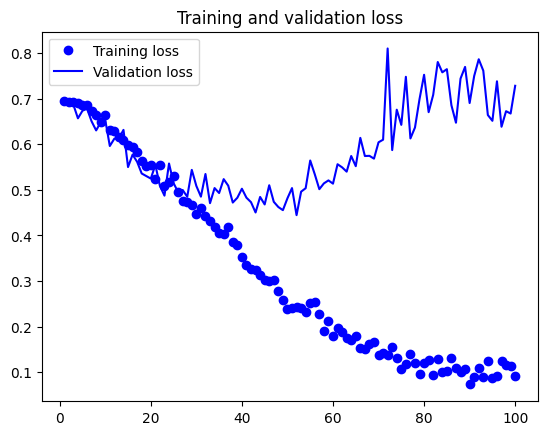

In [22]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [23]:
test_model = keras.models.load_model("convnet_from_scratch_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 7s 112ms/step - loss: 0.5286 - accuracy: 0.8020
Test accuracy:0.802


Scratch model with three modern convnet architectures with Data augmentation  and dropout

Building the model

In [24]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [25]:
set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Configuring the model for training

In [26]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Callback and fitting the model

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_data_augmentation_and_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 112s 2s/step - loss: 0.6780 - accuracy: 0.5930 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 2/100
63/63 [==============================] - 108s 2s/step - loss: 0.6591 - accuracy: 0.6020 - val_loss: 0.7464 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 109s 2s/step - loss: 0.6533 - accuracy: 0.6090 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 109s 2s/step - loss: 0.6361 - accuracy: 0.6320 - val_loss: 0.7497 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 108s 2s/step - loss: 0.6496 - accuracy: 0.6305 - val_loss: 0.7712 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 108s 2s/step - loss: 0.6365 - accuracy: 0.6470 - val_loss: 0.8481 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 108s 2s/step - loss: 0.6095 - accuracy: 0.6735 - val_loss: 0.9165 - val_accuracy: 0.5000
Epoch 

Displaying curves of loss and accuracy during training

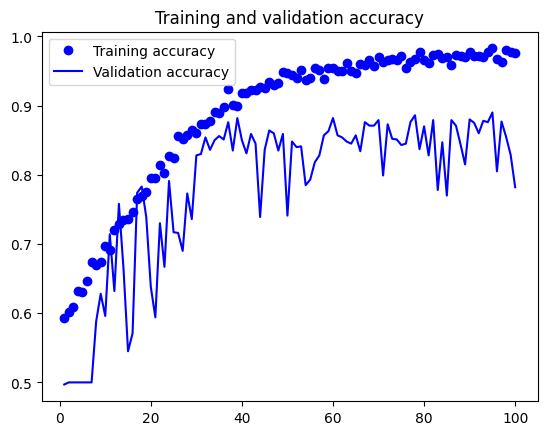

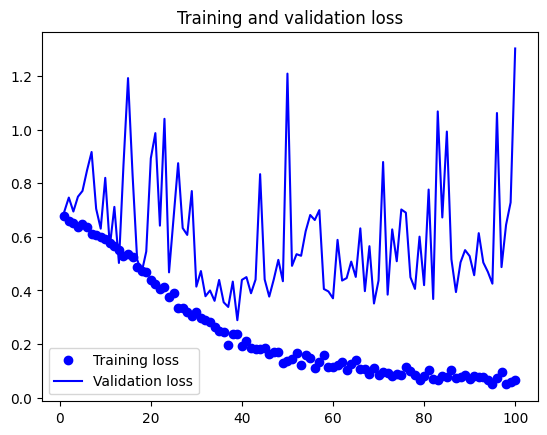

In [28]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


test accuracy

In [29]:
test_model = keras.models.load_model("convnet_with_data_augmentation_and_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 19s 289ms/step - loss: 0.3069 - accuracy: 0.8630
Test accuracy:0.863


In [30]:
new_base_dir = pathlib.Path("cats_vs_dogs_small") 

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Leveraging a pretrained model

Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Fast feature extraction without data augmentation

In [32]:
set_random_seed(42)
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 687ms/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier

In [34]:
set_random_seed(42)
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction_1000.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 10.1444 - accuracy: 0.9380 - val_loss: 8.6809 - val_accuracy: 0.9420
Epoch 2/20
63/63 [==============================] - 1s 23ms/step - loss: 4.3314 - accuracy: 0.9735 - val_loss: 4.3286 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 1s 22ms/step - loss: 1.6961 - accuracy: 0.9875 - val_loss: 6.1469 - val_accuracy: 0.9630
Epoch 4/20
63/63 [==============================] - 1s 22ms/step - loss: 0.9669 - accuracy: 0.9915 - val_loss: 4.8233 - val_accuracy: 0.9690
Epoch 5/20
63/63 [==============================] - 1s 22ms/step - loss: 1.1467 - accuracy: 0.9910 - val_loss: 8.9981 - val_accuracy: 0.9600
Epoch 6/20
63/63 [==============================] - 1s 22ms/step - loss: 0.6698 - accuracy: 0.9945 - val_loss: 5.6620 - val_accuracy: 0.9670
Epoch 7/20
63/63 [==============================] - 1s 22ms/step - loss: 0.4233 - accuracy: 0.9950 - val_loss: 4.9399 - val_accuracy: 0.9700
Epoch 8/20
6

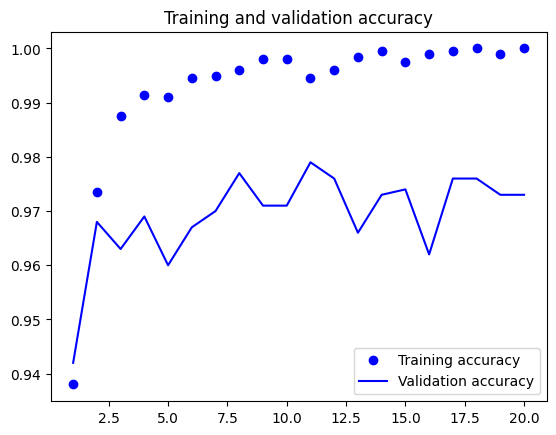

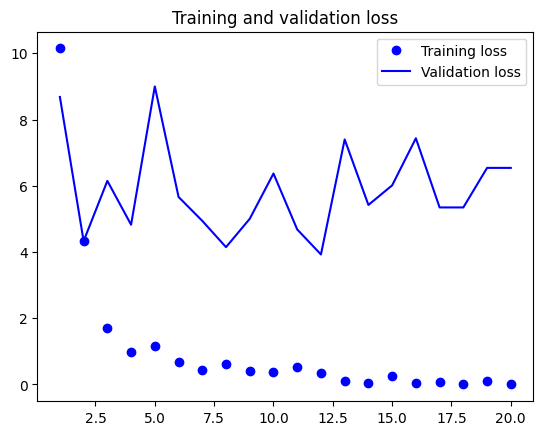

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [36]:
test_model = keras.models.load_model(
    "feature_extraction_1000.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 4.9630 - accuracy: 0.9745
Test accuracy: 0.975


Feature extraction together with data augmentation


In [37]:
set_random_seed(42)
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Adding a data augmentation stage and a classifier to the convolutional base

In [38]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation_1000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 142s 2s/step - loss: 19.7982 - accuracy: 0.8920 - val_loss: 4.0375 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 141s 2s/step - loss: 4.9541 - accuracy: 0.9530 - val_loss: 6.6884 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 145s 2s/step - loss: 5.1037 - accuracy: 0.9625 - val_loss: 5.4444 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 145s 2s/step - loss: 4.0106 - accuracy: 0.9630 - val_loss: 5.5519 - val_accuracy: 0.9670
Epoch 5/50
63/63 [==============================] - 141s 2s/step - loss: 3.0497 - accuracy: 0.9705 - val_loss: 3.1818 - val_accuracy: 0.9750
Epoch 6/50
63/63 [==============================] - 141s 2s/step - loss: 2.4905 - accuracy: 0.9735 - val_loss: 4.7480 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 140s 2s/step - loss: 2.5327 - accuracy: 0.9780 - val_loss: 4.1044 - val_accuracy: 0.9740
Epoch 8/50
6

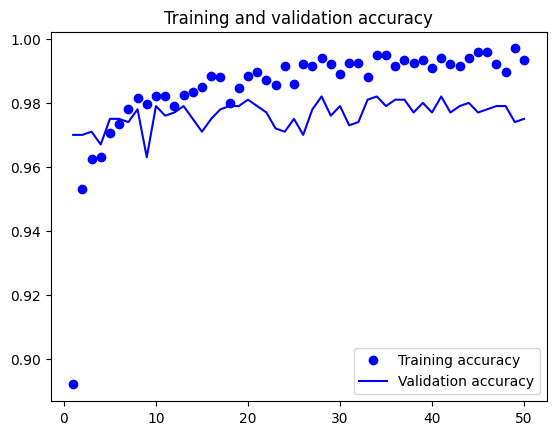

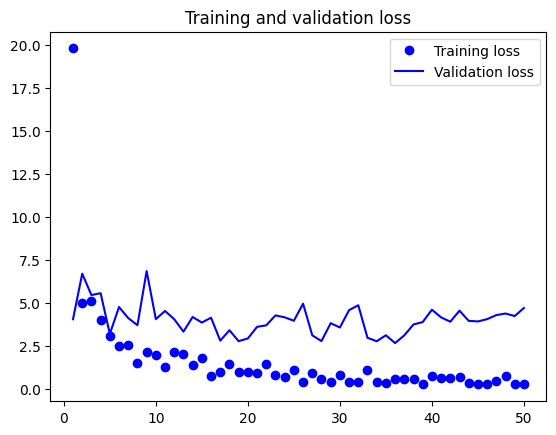

In [40]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation_1000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 92s 1s/step - loss: 3.6525 - accuracy: 0.9755
Test accuracy: 0.975


Fine-tuning a pretrained model

Freezing all layers until the fourth from the last

In [42]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [43]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_1000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 156s 2s/step - loss: 2.5874 - accuracy: 0.9720 - val_loss: 2.9110 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 154s 2s/step - loss: 1.6954 - accuracy: 0.9785 - val_loss: 2.7723 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 153s 2s/step - loss: 1.1783 - accuracy: 0.9795 - val_loss: 2.7337 - val_accuracy: 0.9720
Epoch 4/30
63/63 [==============================] - 153s 2s/step - loss: 1.0060 - accuracy: 0.9815 - val_loss: 2.8236 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 153s 2s/step - loss: 0.8567 - accuracy: 0.9860 - val_loss: 2.6307 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 153s 2s/step - loss: 0.7750 - accuracy: 0.9825 - val_loss: 2.5933 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 154s 2s/step - loss: 0.4062 - accuracy: 0.9905 - val_loss: 2.3160 - val_accuracy: 0.9800
Epoch 8/30
63

In [44]:
model = keras.models.load_model("fine_tuning_1000.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 87s 1s/step - loss: 1.9116 - accuracy: 0.9800
Test accuracy: 0.980


Test with training data - 3000

scratch convnet model with 3000

In [45]:
set_random_seed(42)
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_4000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1500)
make_subset("train", start_index=1500, end_index=4500)

Building the model

In [46]:
set_random_seed(42)
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3))
x=layers.Rescaling(1./255)(inputs)
x=layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x=layers.Flatten()(x)
outputs=layers.Dense(1, activation="sigmoid")(x)
model=keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

Configuring the model for training

In [47]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Data preprocessing

In [48]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Callback and fitting the model

In [49]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_3000.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
188/188 [==============================] - 105s 553ms/step - loss: 0.6884 - accuracy: 0.5222 - val_loss: 0.6849 - val_accuracy: 0.5490
Epoch 2/50
188/188 [==============================] - 98s 523ms/step - loss: 0.6458 - accuracy: 0.6145 - val_loss: 0.6056 - val_accuracy: 0.6780
Epoch 3/50
188/188 [==============================] - 97s 517ms/step - loss: 0.6127 - accuracy: 0.6595 - val_loss: 0.5600 - val_accuracy: 0.7050
Epoch 4/50
188/188 [==============================] - 97s 517ms/step - loss: 0.5448 - accuracy: 0.7218 - val_loss: 0.4857 - val_accuracy: 0.7630
Epoch 5/50
188/188 [==============================] - 97s 516ms/step - loss: 0.4808 - accuracy: 0.7667 - val_loss: 0.4388 - val_accuracy: 0.8050
Epoch 6/50
188/188 [==============================] - 97s 517ms/step - loss: 0.4213 - accuracy: 0.8060 - val_loss: 0.4104 - val_accuracy: 0.8110
Epoch 7/50
188/188 [==============================] - 97s 517ms/step - loss: 0.3810 - accuracy: 0.8337 - val_loss: 0.3903 - val_a

Displaying curves of loss and accuracy during training

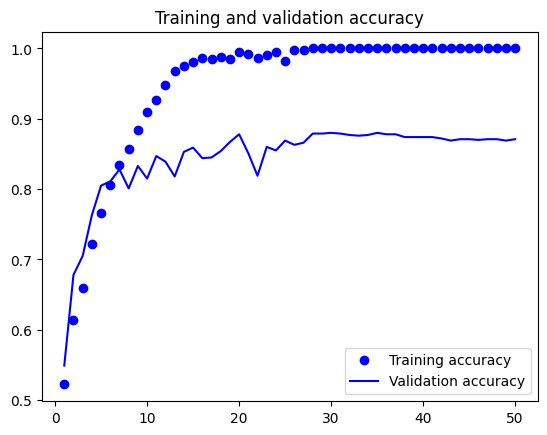

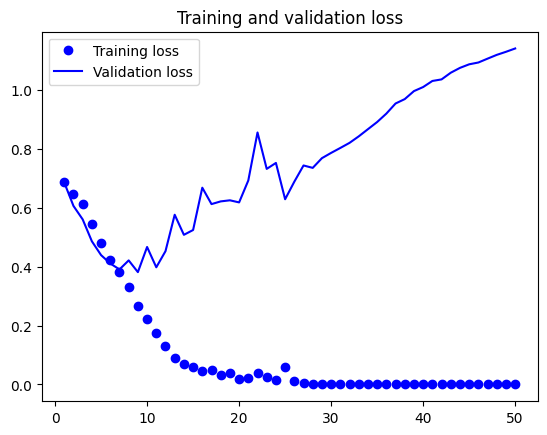

In [50]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Test Accuracy

In [51]:
test_model = keras.models.load_model("convnet_from_scratch_3000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 9s 132ms/step - loss: 0.4125 - accuracy: 0.8385
Test accuracy:0.839


Scratch model with three modern convnet architectures 

Building the model

In [52]:
set_random_seed(42)
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 180, 180, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 176, 176, 32  2400        ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

Configuring the model for training

In [53]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Data preprocessing

In [54]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Callback and fitting the model

In [55]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_modern_architectures_3000.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
188/188 [==============================] - 315s 2s/step - loss: 0.6468 - accuracy: 0.6210 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 2/100
188/188 [==============================] - 313s 2s/step - loss: 0.5879 - accuracy: 0.6992 - val_loss: 0.8369 - val_accuracy: 0.5010
Epoch 3/100
188/188 [==============================] - 313s 2s/step - loss: 0.5179 - accuracy: 0.7503 - val_loss: 1.1358 - val_accuracy: 0.5160
Epoch 4/100
188/188 [==============================] - 310s 2s/step - loss: 0.4423 - accuracy: 0.8000 - val_loss: 0.9296 - val_accuracy: 0.6970
Epoch 5/100
188/188 [==============================] - 305s 2s/step - loss: 0.3730 - accuracy: 0.8382 - val_loss: 0.4374 - val_accuracy: 0.8270
Epoch 6/100
188/188 [==============================] - 305s 2s/step - loss: 0.3072 - accuracy: 0.8695 - val_loss: 0.4031 - val_accuracy: 0.8280
Epoch 7/100
188/188 [==============================] - 306s 2s/step - loss: 0.2555 - accuracy: 0.8922 - val_loss: 0.4929 - val_accuracy:

Displaying curves of loss and accuracy during training

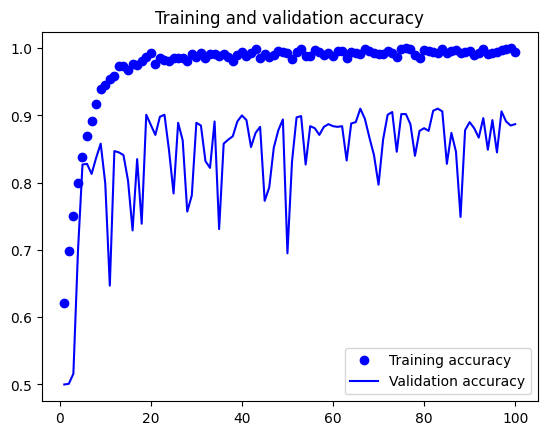

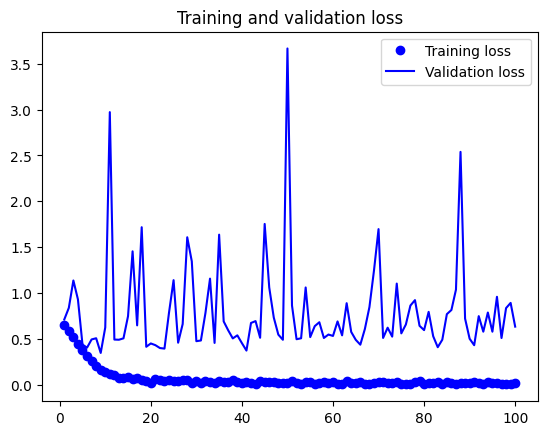

In [56]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


test accuracy 

In [57]:
test_model = keras.models.load_model("convnet_with_modern_architectures_3000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 23s 354ms/step - loss: 0.3792 - accuracy: 0.8515
Test accuracy:0.851


Scratch model with data augmentation and dropout

In [58]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [59]:
set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [60]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_data_augmentation_4000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/100
188/188 [==============================] - 107s 556ms/step - loss: 0.6900 - accuracy: 0.5332 - val_loss: 0.6727 - val_accuracy: 0.5760
Epoch 2/100
188/188 [==============================] - 104s 552ms/step - loss: 0.6726 - accuracy: 0.5822 - val_loss: 0.6757 - val_accuracy: 0.6000
Epoch 3/100
188/188 [==============================] - 104s 552ms/step - loss: 0.6564 - accuracy: 0.6107 - val_loss: 0.6328 - val_accuracy: 0.6440
Epoch 4/100
188/188 [==============================] - 104s 553ms/step - loss: 0.6385 - accuracy: 0.6353 - val_loss: 0.5884 - val_accuracy: 0.6830
Epoch 5/100
188/188 [==============================] - 104s 554ms/step - loss: 0.6110 - accuracy: 0.6707 - val_loss: 0.5566 - val_accuracy: 0.7180
Epoch 6/100
188/188 [==============================] - 104s 555ms/step - loss: 0.5842 - accuracy: 0.6940 - val_loss: 0.4924 - val_accuracy: 0.7820
Epoch 7/100
188/188 [==============================] - 104s 554ms/step - loss: 0.5586 - accuracy: 0.7145 - val_loss: 0

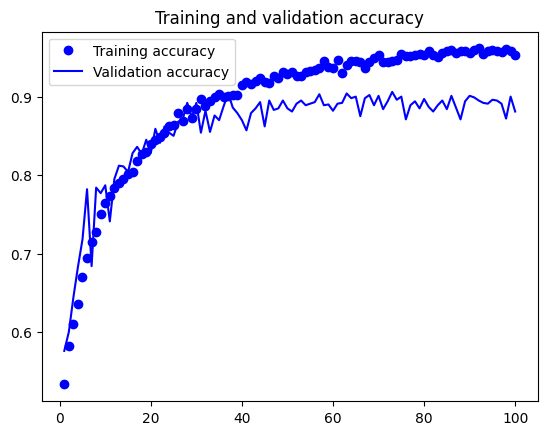

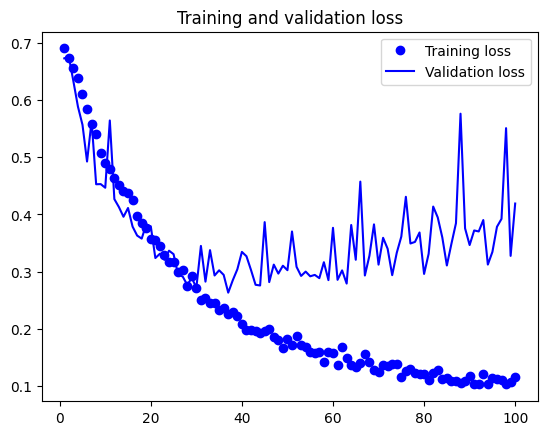

In [61]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [62]:
test_model = keras.models.load_model("convnet_from_scratch_with_data_augmentation_4000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")


63/63 [==============================] - 8s 123ms/step - loss: 0.3055 - accuracy: 0.8770
Test accuracy:0.877


Scratch model with three modern convnet architectures with Data augmentation  and dropout

Building the model

In [63]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [64]:
set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Configuring the model for training

In [65]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


Callback and fitting the model

In [66]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_data_augmentation_and_dropout_3000.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
188/188 [==============================] - 322s 2s/step - loss: 0.6685 - accuracy: 0.5890 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/100
188/188 [==============================] - 317s 2s/step - loss: 0.6443 - accuracy: 0.6185 - val_loss: 0.7599 - val_accuracy: 0.5000
Epoch 3/100
188/188 [==============================] - 321s 2s/step - loss: 0.6182 - accuracy: 0.6480 - val_loss: 0.7464 - val_accuracy: 0.5320
Epoch 4/100
188/188 [==============================] - 319s 2s/step - loss: 0.5743 - accuracy: 0.6990 - val_loss: 0.5738 - val_accuracy: 0.7100
Epoch 5/100
188/188 [==============================] - 319s 2s/step - loss: 0.5341 - accuracy: 0.7312 - val_loss: 0.9573 - val_accuracy: 0.6600
Epoch 6/100
188/188 [==============================] - 318s 2s/step - loss: 0.4762 - accuracy: 0.7727 - val_loss: 0.4570 - val_accuracy: 0.8030
Epoch 7/100
188/188 [==============================] - 318s 2s/step - loss: 0.4538 - accuracy: 0.7902 - val_loss: 0.9508 - val_accuracy:

Displaying curves of loss and accuracy during training

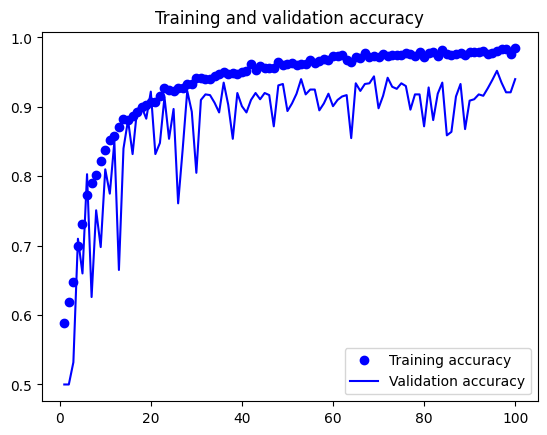

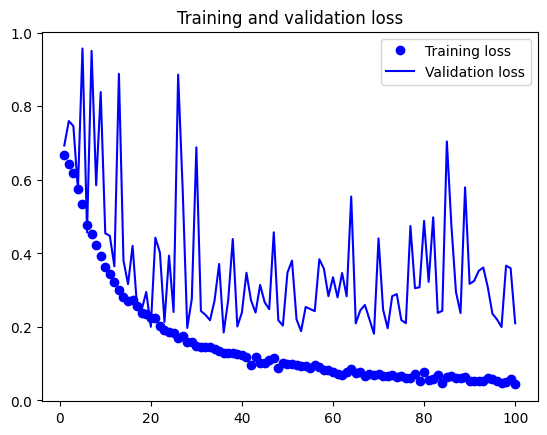

In [67]:
import matplotlib.pyplot as plt

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


test accuracy

In [68]:
test_model = keras.models.load_model("convnet_with_data_augmentation_and_dropout_3000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 21s 333ms/step - loss: 0.2016 - accuracy: 0.9295
Test accuracy:0.929


Leveraging a pretrained model

Instantiating the VGG16 convolutional base

In [69]:
set_random_seed(42)
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Extracting the VGG16 features and corresponding labels

In [70]:
set_random_seed(42)
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 668ms/step


In [71]:
train_features.shape

(6000, 5, 5, 512)

Defining and training the densely connected classifier

In [72]:
set_random_seed(42)
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
188/188 [==============================] - 5s 24ms/step - loss: 9.3268 - accuracy: 0.9493 - val_loss: 5.2701 - val_accuracy: 0.9680
Epoch 2/20
188/188 [==============================] - 4s 24ms/step - loss: 4.1420 - accuracy: 0.9770 - val_loss: 7.3633 - val_accuracy: 0.9680
Epoch 3/20
188/188 [==============================] - 4s 23ms/step - loss: 1.9306 - accuracy: 0.9863 - val_loss: 5.9736 - val_accuracy: 0.9720
Epoch 4/20
188/188 [==============================] - 4s 23ms/step - loss: 1.4413 - accuracy: 0.9902 - val_loss: 9.6112 - val_accuracy: 0.9560
Epoch 5/20
188/188 [==============================] - 4s 23ms/step - loss: 0.9044 - accuracy: 0.9917 - val_loss: 5.3704 - val_accuracy: 0.9750
Epoch 6/20
188/188 [==============================] - 4s 24ms/step - loss: 0.3536 - accuracy: 0.9957 - val_loss: 5.2184 - val_accuracy: 0.9760
Epoch 7/20
188/188 [==============================] - 4s 23ms/step - loss: 0.6410 - accuracy: 0.9948 - val_loss: 7.6798 - val_accuracy: 0.9720

Plotting the results

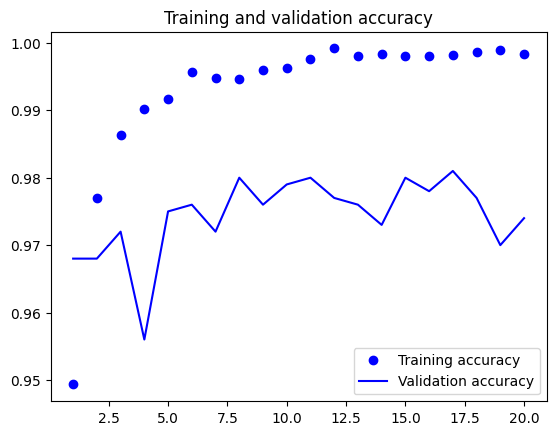

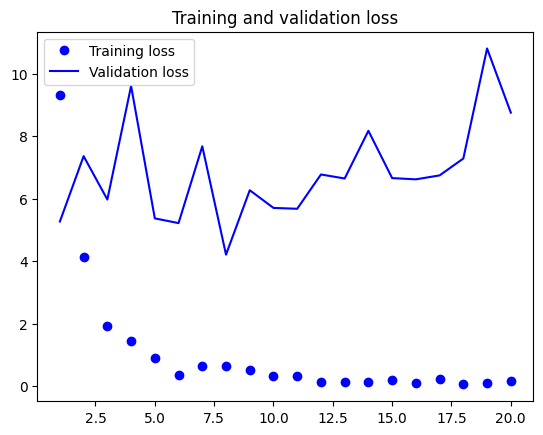

In [73]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [74]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 4ms/step - loss: 5.7436 - accuracy: 0.9715
Test accuracy: 0.971


Feature extraction together with data augmentation


Instantiating and freezing the VGG16 convolutional base



In [75]:
set_random_seed(42)
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Adding a data augmentation stage and a classifier to the convolutional base

In [76]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [77]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation_3000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
188/188 [==============================] - 399s 2s/step - loss: 11.1837 - accuracy: 0.9263 - val_loss: 4.9542 - val_accuracy: 0.9700
Epoch 2/50
188/188 [==============================] - 375s 2s/step - loss: 5.4514 - accuracy: 0.9543 - val_loss: 3.9925 - val_accuracy: 0.9800
Epoch 3/50
188/188 [==============================] - 374s 2s/step - loss: 3.7611 - accuracy: 0.9595 - val_loss: 2.7230 - val_accuracy: 0.9760
Epoch 4/50
188/188 [==============================] - 375s 2s/step - loss: 2.3580 - accuracy: 0.9663 - val_loss: 1.7647 - val_accuracy: 0.9830
Epoch 5/50
188/188 [==============================] - 377s 2s/step - loss: 2.0348 - accuracy: 0.9642 - val_loss: 2.0364 - val_accuracy: 0.9760
Epoch 6/50
188/188 [==============================] - 379s 2s/step - loss: 1.4713 - accuracy: 0.9687 - val_loss: 1.5263 - val_accuracy: 0.9750
Epoch 7/50
188/188 [==============================] - 375s 2s/step - loss: 1.1545 - accuracy: 0.9680 - val_loss: 1.1515 - val_accuracy: 0.977

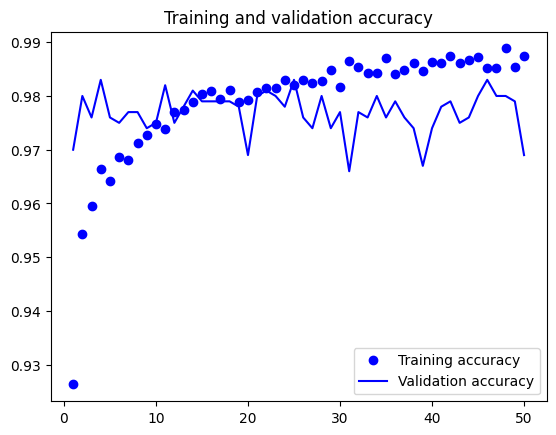

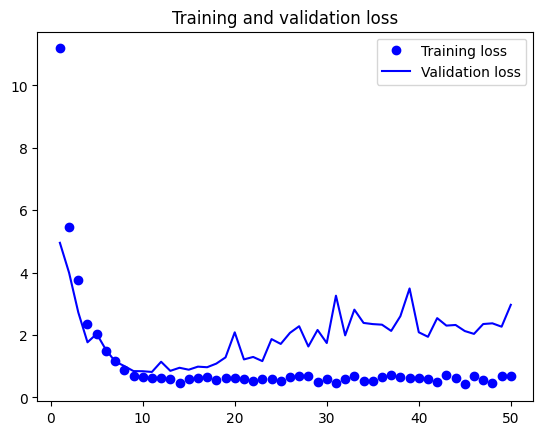

In [78]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [79]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation_3000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 102s 2s/step - loss: 1.0314 - accuracy: 0.9735
Test accuracy: 0.974


Fine-tuning a pretrained model

Freezing all layers until the fourth from the last

In [80]:
set_random_seed(42)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [81]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_3000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
188/188 [==============================] - 446s 2s/step - loss: 0.6470 - accuracy: 0.9837 - val_loss: 2.6285 - val_accuracy: 0.9780
Epoch 2/30
188/188 [==============================] - 443s 2s/step - loss: 0.4234 - accuracy: 0.9883 - val_loss: 2.2044 - val_accuracy: 0.9740
Epoch 3/30
188/188 [==============================] - 445s 2s/step - loss: 0.4288 - accuracy: 0.9885 - val_loss: 1.5450 - val_accuracy: 0.9770
Epoch 4/30
188/188 [==============================] - 447s 2s/step - loss: 0.3621 - accuracy: 0.9878 - val_loss: 1.4782 - val_accuracy: 0.9830
Epoch 5/30
188/188 [==============================] - 447s 2s/step - loss: 0.2387 - accuracy: 0.9923 - val_loss: 1.2174 - val_accuracy: 0.9850
Epoch 6/30
188/188 [==============================] - 451s 2s/step - loss: 0.3668 - accuracy: 0.9893 - val_loss: 1.6810 - val_accuracy: 0.9810
Epoch 7/30
188/188 [==============================] - 450s 2s/step - loss: 0.3014 - accuracy: 0.9917 - val_loss: 2.0317 - val_accuracy: 0.9710

In [82]:
model = keras.models.load_model("fine_tuning_3000.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 101s 2s/step - loss: 1.5949 - accuracy: 0.9795
Test accuracy: 0.979


Test with training data -6000

In [2]:
from keras.utils import set_random_seed
set_random_seed(42)
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_6000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1500)
make_subset("train", start_index=1500, end_index=7500)

Scratch model with three modern convnet architectures with Data augmentation  and dropout

In [6]:
set_random_seed(42)
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [7]:
set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 12000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_with_data_augmentation_and_dropout_6000.keras",
        save_best_only=True,
        monitor="val_loss")
]

history=model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
375/375 [==============================] - 650s 2s/step - loss: 0.6601 - accuracy: 0.6045 - val_loss: 0.8370 - val_accuracy: 0.5000
Epoch 2/100
375/375 [==============================] - 627s 2s/step - loss: 0.6002 - accuracy: 0.6791 - val_loss: 0.7621 - val_accuracy: 0.5630
Epoch 3/100
375/375 [==============================] - 624s 2s/step - loss: 0.5297 - accuracy: 0.7377 - val_loss: 0.8743 - val_accuracy: 0.6100
Epoch 4/100
375/375 [==============================] - 630s 2s/step - loss: 0.4655 - accuracy: 0.7776 - val_loss: 0.4728 - val_accuracy: 0.7880
Epoch 5/100
375/375 [==============================] - 622s 2s/step - loss: 0.4131 - accuracy: 0.8108 - val_loss: 0.9932 - val_accuracy: 0.6510
Epoch 6/100
375/375 [==============================] - 623s 2s/step - loss: 0.3628 - accuracy: 0.8416 - val_loss: 0.3961 - val_accuracy: 0.8210
Epoch 7/100
375/375 [==============================] - 624s 2s/step - loss: 0.3214 - accuracy: 0.8597 - val_loss: 0.2492 - val_accuracy:

In [13]:
test_model = keras.models.load_model("convnet_with_data_augmentation_and_dropout_6000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy:{test_acc:.3f}")

63/63 [==============================] - 24s 367ms/step - loss: 0.1396 - accuracy: 0.9500
Test accuracy:0.950


Feature extraction together with data augmentation


In [14]:
set_random_seed(42)
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [15]:
set_random_seed(42)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

set_random_seed(42)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation_6000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
375/375 [==============================] - 592s 2s/step - loss: 8.9322 - accuracy: 0.9311 - val_loss: 3.7249 - val_accuracy: 0.9730
Epoch 2/50
375/375 [==============================] - 591s 2s/step - loss: 3.5243 - accuracy: 0.9537 - val_loss: 1.3874 - val_accuracy: 0.9810
Epoch 3/50
375/375 [==============================] - 591s 2s/step - loss: 1.3914 - accuracy: 0.9571 - val_loss: 0.6837 - val_accuracy: 0.9690
Epoch 4/50
375/375 [==============================] - 593s 2s/step - loss: 0.6925 - accuracy: 0.9615 - val_loss: 0.6088 - val_accuracy: 0.9790
Epoch 5/50
375/375 [==============================] - 590s 2s/step - loss: 0.6828 - accuracy: 0.9613 - val_loss: 0.7808 - val_accuracy: 0.9720
Epoch 6/50
375/375 [==============================] - 592s 2s/step - loss: 0.6923 - accuracy: 0.9645 - val_loss: 0.4806 - val_accuracy: 0.9790
Epoch 7/50
375/375 [==============================] - 595s 2s/step - loss: 0.6834 - accuracy: 0.9651 - val_loss: 0.4500 - val_accuracy: 0.9810

In [17]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation_6000.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 88s 1s/step - loss: 0.6231 - accuracy: 0.9765
Test accuracy: 0.976


Fine-tuning a pretrained model

In [18]:
set_random_seed(42)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [19]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_6000.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
375/375 [==============================] - 714s 2s/step - loss: 0.8262 - accuracy: 0.9797 - val_loss: 1.6526 - val_accuracy: 0.9760
Epoch 2/30
375/375 [==============================] - 709s 2s/step - loss: 0.6202 - accuracy: 0.9818 - val_loss: 1.0395 - val_accuracy: 0.9780
Epoch 3/30
375/375 [==============================] - 711s 2s/step - loss: 0.4467 - accuracy: 0.9852 - val_loss: 1.0090 - val_accuracy: 0.9770
Epoch 4/30
375/375 [==============================] - 713s 2s/step - loss: 0.3924 - accuracy: 0.9840 - val_loss: 0.7818 - val_accuracy: 0.9810
Epoch 5/30
375/375 [==============================] - 714s 2s/step - loss: 0.3035 - accuracy: 0.9868 - val_loss: 0.9737 - val_accuracy: 0.9780
Epoch 6/30
375/375 [==============================] - 711s 2s/step - loss: 0.3250 - accuracy: 0.9840 - val_loss: 0.5518 - val_accuracy: 0.9870
Epoch 7/30
375/375 [==============================] - 713s 2s/step - loss: 0.2259 - accuracy: 0.9882 - val_loss: 0.6650 - val_accuracy: 0.9870

In [20]:
model = keras.models.load_model("fine_tuning_6000.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 88s 1s/step - loss: 0.5499 - accuracy: 0.9850
Test accuracy: 0.985
